# Introduction

In this notebook, we'll implement simple RNNs, then explore how gradients flow through networks.

In [ ]:
! pip install ipympl

In [ ]:
import copy

# If you are not using colab you can delete these two lines
from google.colab import output
output.enable_custom_widget_manager()

import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, Layout

In [ ]:
%matplotlib ipympl

# 1.A: implementing a RNN layer

In [ ]:
class RNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size, nonlinearity=th.tanh):
    """
    Initialize a single RNN layer.

    Inputs:
    - input_size: Data input feature dimension
    - hidden_size: RNN hidden state size (also the output feature dimension)
    - nonlinearity: Nonlinearity applied to the rnn output
    """
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.nonlinearity = nonlinearity

    self.Wxh = nn.Parameter(th.randn(input_size, hidden_size))


    self.Whh = nn.Parameter(th.randn(hidden_size, hidden_size))


    self.bh = nn.Parameter(th.zeros(hidden_size))

  def forward(self, x):
    """
    RNN forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep
    - last_h: hidden state from the last timestep (B, hidden_size)
    """
    h_list = []  # List to store the hidden states [h_1, ... h_T]

    # 1. Initialize h0 with zeros
    B, seq_len, _ = x.size()
    h = th.zeros(B, self.hidden_size).to(x.device)
    # 2. Roll out the RNN over the sequence, storing hidden states in h_list
    for t in range(seq_len):
      h = self.nonlinearity(th.matmul(x[:, t, :], self.Wxh) + th.matmul(h, self.Whh) + self.bh)
      h_list.append(h)

    # 3. Return the appropriate outputs
    self.store_h_for_grad(h_list)
    all_h = th.stack(h_list, dim=1)
    last_h = h_list[-1]
    return all_h, last_h

    self.store_h_for_grad(h_list)
    all_h = th.stack(h_list, dim=1)
    return all_h, last_h

  def store_h_for_grad(self, h_list):
    """
    Store input list and allow gradient computation for all list elements
    """
    for h in h_list:
      h.retain_grad()
    self.h_list = h_list


### Test Cases

In [ ]:
rnn = RNNLayer(1, 1)
# Overwrite initial parameters with fixed values.
# Should give deterministic results even with different implementations.
rnn.load_state_dict({k: v * 0 + .1 for k, v in rnn.state_dict().items()})
data = th.ones((1, 1, 1))
expected_out = th.FloatTensor([[[0.1973753273487091]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_out.shape
assert th.all(th.isclose(all_h, last_h))
print(f'Expected: {expected_out.item()}, got: {last_h.item()}, max error: {th.max(th.abs(expected_out - last_h)).item()}')

rnn = RNNLayer(2, 3, nonlinearity=lambda x: x)  # no nonlinearity

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 18, f'expected 18 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1250, -0.1250, -0.1250],
         [-0.1075, -0.1075, -0.1075],
         [-0.1328, -0.1328, -0.1328],
         [-0.1452, -0.1452, -0.1452]],

        [[ 0.0600,  0.0600,  0.0600],
         [ 0.1520,  0.1520,  0.1520],
         [ 0.2344,  0.2344,  0.2344],
         [-0.0853, -0.0853, -0.0853]]])
expected_last_h = th.FloatTensor([[-0.1452, -0.1452, -0.1452],
        [-0.0853, -0.0853, -0.0853]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

Expected: 0.1973753273487091, got: 0.1973753273487091, max error: 0.0
Max error all_h: 4.999339580535889e-05
Max error last_h: 2.498924732208252e-05


# 1.B Implementing a RNN regression model.


In [ ]:
class RecurrentRegressionModel(nn.Module):
  def __init__(self, recurrent_net, output_dim=1):
    """
    Initialize a simple RNN regression model

    Inputs:
    - recurrent_net: an RNN or LSTM (single or multi layer)
    - output_dim: feature dimension of the output
    """
    super().__init__()
    self.recurrent_net = recurrent_net
    self.output_dim = output_dim

    self.fc = nn.Linear(recurrent_net.hidden_size, output_dim)

  def forward(self, x):
    """
    Forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - out: predictions of shape (B, seq_len, self.output_dim).
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep.
    """


    all_h, _ = self.recurrent_net(x)
    out = self.fc(all_h)

    return out, all_h


## Tests

In [ ]:
rnn = RecurrentRegressionModel(RNNLayer(2, 3), 4)

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 34, f'expected 34 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_preds = th.FloatTensor([[[-0.0627, -0.0627, -0.0627, -0.0627],
         [-0.0678, -0.0678, -0.0678, -0.0678],
         [-0.0604, -0.0604, -0.0604, -0.0604],
         [-0.0567, -0.0567, -0.0567, -0.0567]],

        [[-0.1180, -0.1180, -0.1180, -0.1180],
         [-0.1453, -0.1453, -0.1453, -0.1453],
         [-0.1692, -0.1692, -0.1692, -0.1692],
         [-0.0748, -0.0748, -0.0748, -0.0748]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
preds, all_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert preds.shape == expected_preds.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_preds - preds)).item()}')

Max error all_h: 4.699826240539551e-05
Max error last_h: 4.3138861656188965e-05


# 1.C: Dataset and loss function

## 1.C.i: Understanding the dataset

Visualizing dataset using plots

In [ ]:
def generate_batch(seq_len=10, batch_size=1):
  data = th.randn(size=(batch_size, seq_len, 1))
  sums = th.cumsum(data, dim=1)
  div = (th.arange(seq_len) + 1).unsqueeze(0).unsqueeze(2)
  target = sums / div
  return data, target

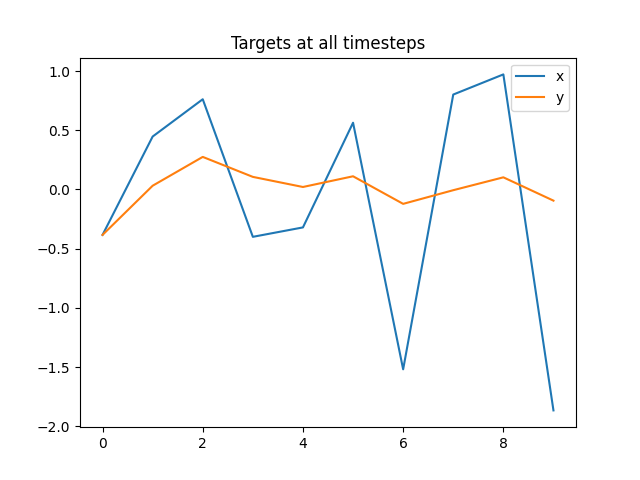

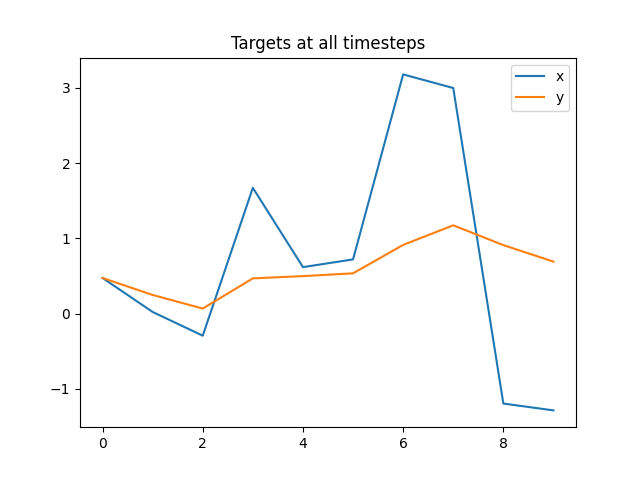

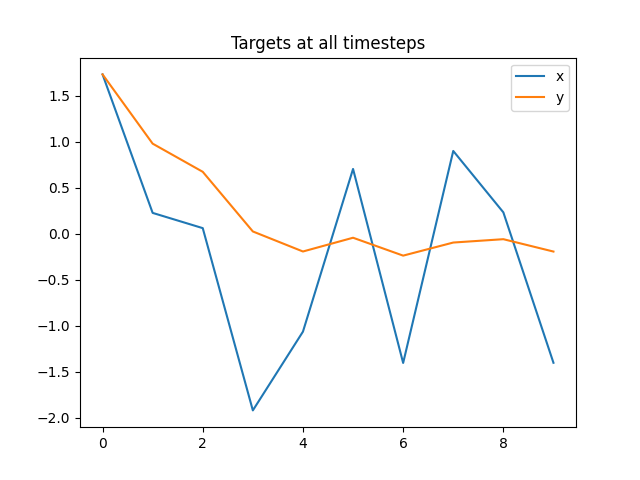

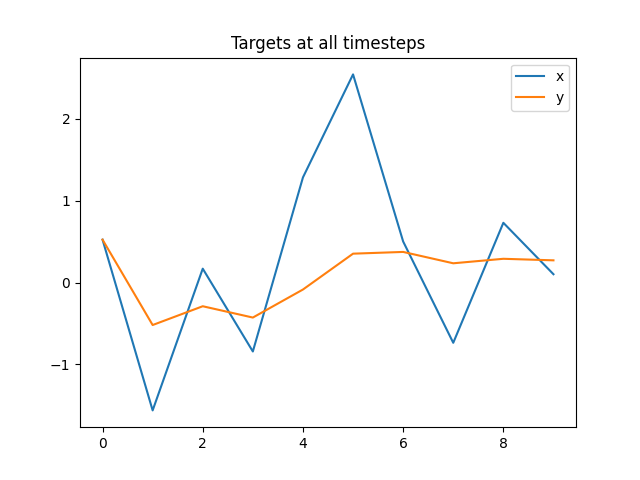

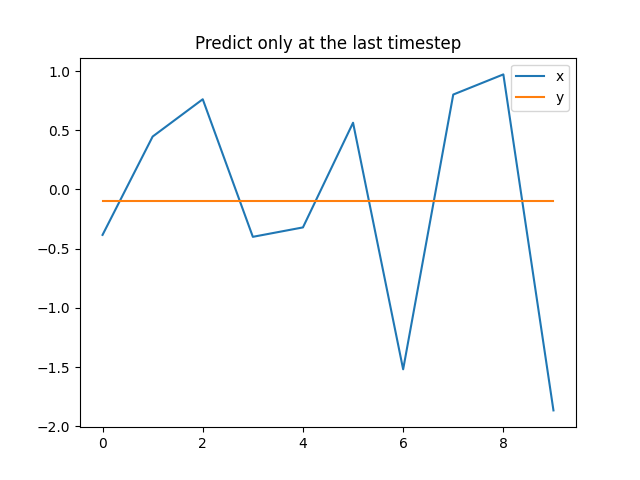

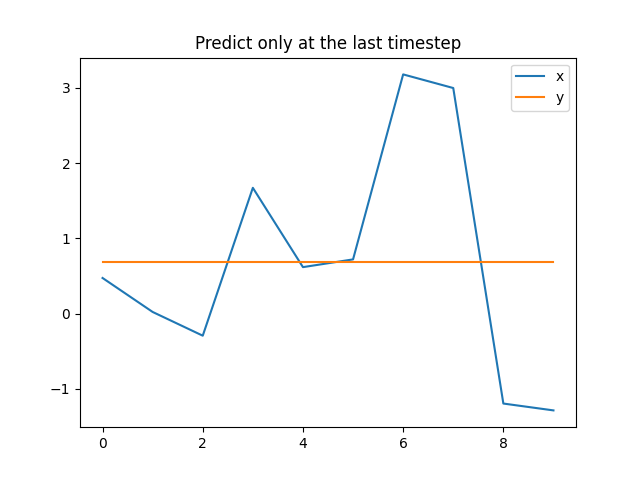

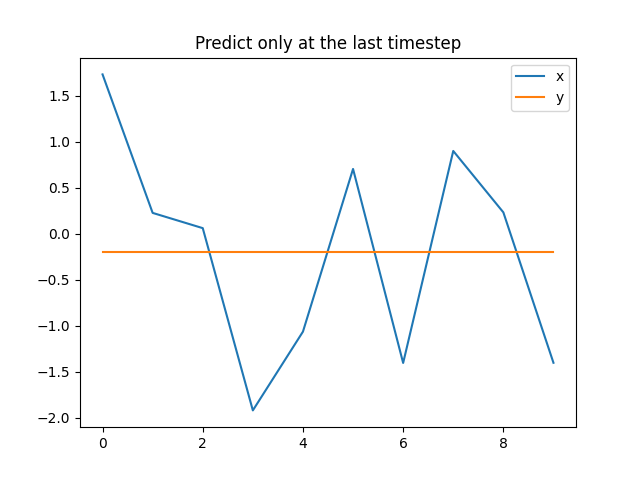

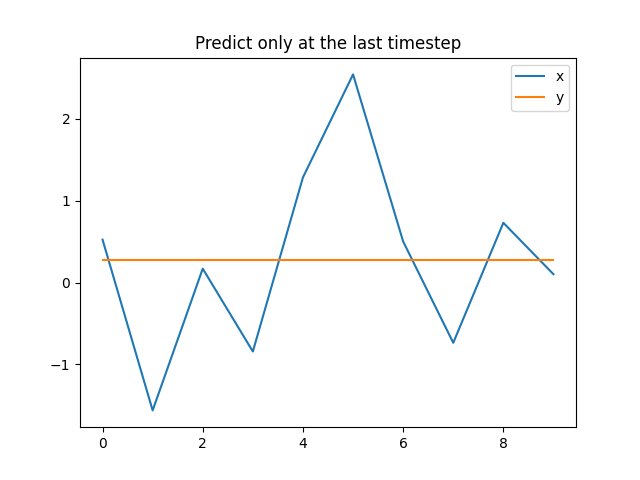

In [ ]:
x, y = generate_batch(seq_len=10, batch_size=4)
for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(y[i, :, 0])
  ax1.legend(['x', 'y'])
  plt.title('Targets at all timesteps')
  plt.show()

for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(np.arange(10), [y[i, -1].item()] * 10)
  ax1.legend(['x', 'y'])
  plt.title('Predict only at the last timestep')
  plt.show()

## 1.C.ii Implement the loss function

In [ ]:
def loss_fn(pred, y, last_timestep_only=False):
  """
  Inputs:
  - pred: model predictions of size (batch, seq_len, 1)
  - y: targets of size (batch, seq_len, 1)
  - last_timestep_only: boolean indicating whether to compute loss for all
    timesteps or only the lat

  Returns:
  - loss: scalar MSE loss between pred and true labels
  """
  mse_loss = nn.MSELoss()

  if last_timestep_only:
      loss = mse_loss(pred[:, -1], y[:, -1])
  else:
      loss = mse_loss(pred, y)

  return loss

### Tests

In [ ]:
pred = th.FloatTensor([[.1, .2, .3], [.4, .5, .6]])
y = th.FloatTensor([[-1.1, -1.2, -1.3], [-1.4, -1.5, -1.6]])
loss_all = loss_fn(pred, y, last_timestep_only=False)
loss_last = loss_fn(pred, y, last_timestep_only=True)
assert loss_all.shape == loss_last.shape == th.Size([])
print(f'Max error loss_all: {th.abs(loss_all - th.tensor(3.0067)).item()}')
print(f'Max error loss_last: {th.abs(loss_last - th.tensor(3.7)).item()}')

Max error loss_all: 3.314018249511719e-05
Max error loss_last: 2.384185791015625e-07


# 1.D: Analyzing RNN Gradients

You do not need to understand the details of the GradientVisualizer class in order to complete this problem.

In [ ]:
def biggest_eig_magnitude(matrix):
  """
  Inputs: a square matrix
  Returns: the scalar magnitude of the largest eigenvalue
  """
  h, w = matrix.shape
  assert h == w, f'Matrix has shape {matrix.shape}, but eigenvalues can only be computed for square matrices'
  eigs = th.linalg.eigvals(matrix)
  eig_magnitude = eigs.abs()
  eigs_sorted = sorted([i.item() for i in eig_magnitude], reverse=True)
  first_eig_magnitude = eigs_sorted[0]
  return first_eig_magnitude

class GradientVisualizer:

  def __init__(self, rnn, last_timestep_only):
    """
    Inputs:
    - rnn: rnn module
    - last_timestep_only: boolean indicating whether to compute loss for all
      timesteps or only the lat

    Returns:
    - loss: scalar MSE loss between pred and true labels
    """

    self.rnn = rnn
    self.last_timestep_only = last_timestep_only
    self.model = RecurrentRegressionModel(rnn)
    self.original_weights = copy.deepcopy(rnn.state_dict())

    # Generate a single batch to be used repeatedly
    self.x, self.y = generate_batch(seq_len=10)
    print(f'Data point: x={np.round(self.x[0, :, 0].detach().cpu().numpy(), 2)}, y={np.round(self.y.squeeze().detach().cpu().numpy(), 2)}')

  def plot_visuals(self):
    """ Generate plots which will be updated in realtime."""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('RNN Outputs')
    ax1.set_xlabel('Unroll Timestep')
    ax1.set_ylabel('Hidden State Norm')
    ax1.set_ylim(-1, 5)
    plt_1 = ax1.plot(np.arange(1, 11), np.zeros(10) + 1)  # placeholder vals
    plt_1 = plt_1[0]

    ax2.set_title('Gradients')
    ax2.set_xlabel('Unroll Timestep')
    ax2.set_ylabel('RNN dLoss/d a_t Gradient Magitude')
    ax2.set_ylim( (10**-6,1e5) )
    ax2.set_yscale('log')
    # X-axis labels are reversed since the gradient flow is from later layers to earlier layers
    ax2.set_xticks(np.arange(10), np.arange(10, 0, -1))
    plt_2 = ax2.plot(np.arange(10), np.arange(10) + 1)  # placeholder vals
    plt_2 = plt_2[0]
    self.fig = fig
    self.plots = [plt_1, plt_2]
    return plt_1, plt_2, fig

  # Main update function for interactive plot
  def update_plots(self, weight_val=0, bias_val=0):
    # Scale the original RNN weights by a constant
    w_dict = copy.deepcopy(self.original_weights)

    for k in w_dict.keys():
      if 'weight' in k:
        w_dict[k][:] *= weight_val
      elif 'bias' in k:
        w_dict[k][:] *= bias_val

    self.rnn.load_state_dict(w_dict)

    # Don't compute for LSTMs, which don't have behavior dependent on a single eigenvalue
    if isinstance(self.rnn, RNNLayer):

      W = self.rnn.Wxh
      W = W.view(4,4)

      biggest_eig = biggest_eig_magnitude(W)
      print(f' Biggest eigenvalue magnitude: {biggest_eig:.3}')

    # Run model
    pred, h = self.model(self.x)
    loss = loss_fn(pred, self.y, self.last_timestep_only)
    n_steps = len(h[0])

    plt_1, plt_2 = self.plots

    # Plot the hidden state magnitude
    max_h = th.linalg.norm(h[0], dim=-1).detach().cpu().numpy()
    print('Max H', ' '.join([f'{num:.3}' for num in max_h]))
    plt_1.set_data(np.arange(1, n_steps + 1), np.array(max_h))
    # Compute the gradient for the loss wrt the stored hidden states
    # Gradients are plotted backward since we go from later layers to earlier
    grads = [th.linalg.norm(num).item() for num in th.autograd.grad(loss, self.rnn.h_list)][::-1]
    print('gradients d Loss/d h_t', ' '.join([f'{num:.3}' for num in grads]))
    # Add 1e-6 since it throws an error for gradients near 0
    plt_2.set_data(np.arange(n_steps), np.array(grads) + 1e-6)
    self.fig.canvas.draw_idle()

  def create_visualization(self):
    # Include sliders for relevant quantities
    self.plot_visuals()
    ip = interactive(self.update_plots,
                    weight_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="weight_scale", layout=Layout(width='100%')),
                    bias_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="bias_scale", layout=Layout(width='100%')),
                    )
    return ip

Data point: x=[-0.76  0.15 -0.41  0.81  0.11 -2.32 -1.19 -1.59 -0.39  1.37], y=[-0.76 -0.3  -0.34 -0.05 -0.02 -0.4  -0.51 -0.65 -0.62 -0.42]


interactive(children=(FloatSlider(value=0.0, description='weight_scale', layout=Layout(width='100%'), max=5.0,…

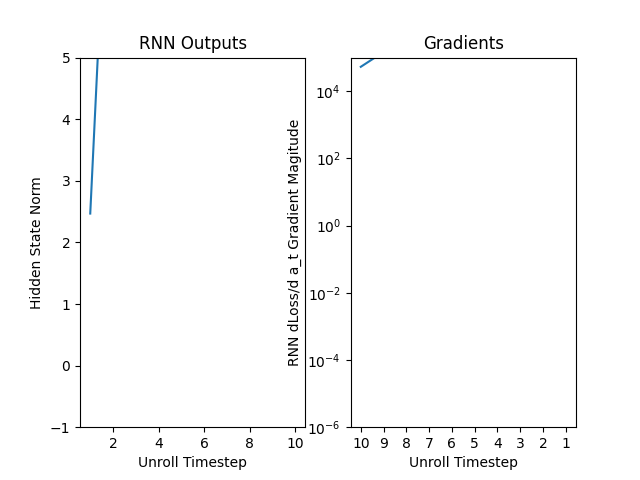

In [ ]:
hidden_size = 16
nonlinearity = lambda x: x  # options include lambda x: x (no nonlinearity), nn.functional.relu, and th.tanh
last_target_only = True
rnn = RNNLayer(1, hidden_size, nonlinearity=nonlinearity)
gv = GradientVisualizer(rnn, last_target_only)
gv.create_visualization()

#gv.update_plots(weight_val=0.5, bias_val=0.5)
# If for some reason the slider doesn't work for you, try calling gv.update_plots
# with various values for weight and bias

# 2.a RNN for Last Name Classification 

Training a neural network to predict the probable language of origin for a given last name / family name in Latin alphabets.


## Download Data

In [ ]:
import os

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

--2023-11-22 08:27:52--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.77, 18.160.200.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2023-11-22 08:27:53 (36.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names

## Library imports

Before starting, make sure you have all these libraries.

In [ ]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [ ]:
%load_ext autoreload
%autoreload 2

## Implement the Neural Network

In [ ]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = 'lstm'
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type

        # Create an embedding layer of shape [vocab_size, rnn_size]
        self.embedding = nn.Embedding(vocab_size, rnn_size)



        # Create a RNN stack with `num_layers` layers with tanh
        #       nonlinearity. Between each layers, there is a dropout of
        #       `dropout`. Implement it with a *single* call to `torch.nn` APIs

        if model_type == 'lstm':
            self.lstm = NotImplementedError()
        elif model_type == 'rnn':
            self.rnn = nn.RNN(
                rnn_size, rnn_size, num_layers, nonlinearity='tanh', dropout=dropout, batch_first=True
            )

        # Implement one dropout layer and the fully-connected classifier layer
        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(rnn_size, n_categories)

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)
        if self.model_type == 'lstm':
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        # Retrieve the output state associated with each sequence
        out = rnn_out[torch.arange(rnn_out.size(0)), last_pos]

        out = self.drop(out)
        logits = self.output(out)
        return logits


In [ ]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [ ]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0',
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

In [ ]:
x = torch.arange(20).view(5, 4) % 11
last_pos = torch.tensor([2, 3, 1, 2, 3])
seed = 1025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logits = model(x, last_pos)
assert logits.shape == torch.Size([5, 17])
assert torch.allclose(
    logits.view(-1)[40:45],
    torch.tensor(
        [
            -0.27393126487731934,
            0.28421181440353394,
            0.2342953234910965,
            0.23580458760261536,
            0.06812290847301483
        ],
        dtype=torch.float
    )
)

model.zero_grad()
logits.sum().backward()
assert torch.allclose(
    model.rnn.weight_hh_l0.grad.view(-1)[40:45],
    torch.tensor(
        [
            -0.9424352645874023,
            -0.488606333732605,
            0.6905138492584229,
            -0.0017577260732650757,
            1.1024625301361084
        ],
        dtype=torch.float
    )
)

## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [ ]:
def letterToIndex(letter):

    return all_letters.find(letter)


assert letterToIndex("a") == 0
assert letterToIndex("'") == 56

In [ ]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character
vocab_size = 58 # number of characters used in total

In [ ]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [ ]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [ ]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [ ]:
len(train_data)

16059

In [ ]:
train_data[0]

(array([37, 14, 18, 10, 20, 19, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 11,
 7)

In [ ]:
len(test_data)

4015

In [ ]:
test_data[0]

(array([33,  0, 13,  3, 14,  7,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 11,
 7)

# 2.b Train the model

In [ ]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [ ]:
build_batch(train_data, [1, 2, 3])

(array([[43,  7, 14,  0,  3,  4, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [37,  4, 25,  7,  4, 15,  4, 10, 14, 21, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [29,  9, 20, 12,  0,  6,  0, 11,  8,  4, 21, 57, 57, 57, 57, 57,
         57, 57, 57]]),
 array([ 3, 11, 11]),
 array([ 6,  9, 10]))

**Adjusting hyperparameters below** 

In [ ]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())

############################################################################
# TODO: Tune these hyperparameters for a better performance
############################################################################
hidden_size = 256
num_layers = 2
dropout = 0.3
optimizer_class = optim.Adam
lr = 0.001
batch_size = 256
############################################################################

# Do not change the number of epochs
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [ ]:
# Optional
# lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
# lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [ ]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [ ]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 59  Loss: 0.9559145569801331: 100%|██████████| 63/63 [00:00<00:00, 102.26it/s]


Epoch: 0  Train Accuracy: 63.385017747057724
Epoch: 0  Eval Accuracy: 72.10460772104608


Epoch: 1  Iteration: 59  Loss: 0.8237442970275879: 100%|██████████| 63/63 [00:00<00:00, 136.90it/s]


Epoch: 1  Train Accuracy: 74.98598916495423
Epoch: 1  Eval Accuracy: 75.96513075965132


Epoch: 2  Iteration: 59  Loss: 0.6634817540645599: 100%|██████████| 63/63 [00:00<00:00, 148.47it/s]


Epoch: 2  Train Accuracy: 78.57276293667103
Epoch: 2  Eval Accuracy: 76.96139476961395


Epoch: 3  Iteration: 59  Loss: 0.6317961096763611: 100%|██████████| 63/63 [00:00<00:00, 148.97it/s]


Epoch: 3  Train Accuracy: 80.68995578803163
Epoch: 3  Eval Accuracy: 79.82565379825654


Epoch: 4  Iteration: 59  Loss: 0.5713737934827805: 100%|██████████| 63/63 [00:00<00:00, 150.62it/s]


Epoch: 4  Train Accuracy: 82.45843452269756
Epoch: 4  Eval Accuracy: 80.09962640099626


Epoch: 5  Iteration: 59  Loss: 0.5354659557342529: 100%|██████████| 63/63 [00:00<00:00, 143.55it/s]


Epoch: 5  Train Accuracy: 83.41739834360794
Epoch: 5  Eval Accuracy: 81.54420921544208


Epoch: 6  Iteration: 59  Loss: 0.49613210260868074: 100%|██████████| 63/63 [00:00<00:00, 141.94it/s]


Epoch: 6  Train Accuracy: 84.45108661809577
Epoch: 6  Eval Accuracy: 81.64383561643835


Epoch: 7  Iteration: 59  Loss: 0.4860502392053604: 100%|██████████| 63/63 [00:00<00:00, 150.50it/s]


Epoch: 7  Train Accuracy: 85.23569338065882
Epoch: 7  Eval Accuracy: 81.89290161892902


Epoch: 8  Iteration: 59  Loss: 0.4537526160478592: 100%|██████████| 63/63 [00:00<00:00, 148.81it/s]


Epoch: 8  Train Accuracy: 86.6741391120244
Epoch: 8  Eval Accuracy: 81.99252801992529


Epoch: 9  Iteration: 59  Loss: 0.4199981242418289: 100%|██████████| 63/63 [00:00<00:00, 150.16it/s]


Epoch: 9  Train Accuracy: 87.15362102247961
Epoch: 9  Eval Accuracy: 82.44084682440847


Epoch: 10  Iteration: 59  Loss: 0.3580572962760925: 100%|██████████| 63/63 [00:00<00:00, 149.31it/s]


Epoch: 10  Train Accuracy: 87.80123295348403
Epoch: 10  Eval Accuracy: 82.44084682440847


Epoch: 11  Iteration: 59  Loss: 0.379392871260643: 100%|██████████| 63/63 [00:00<00:00, 150.44it/s]


Epoch: 11  Train Accuracy: 88.5920667538452
Epoch: 11  Eval Accuracy: 82.24159402241594


Epoch: 12  Iteration: 59  Loss: 0.3942785710096359: 100%|██████████| 63/63 [00:00<00:00, 151.47it/s]


Epoch: 12  Train Accuracy: 88.95946198393425
Epoch: 12  Eval Accuracy: 83.21295143212951


Epoch: 13  Iteration: 59  Loss: 0.3188412845134735: 100%|██████████| 63/63 [00:00<00:00, 148.97it/s]


Epoch: 13  Train Accuracy: 89.52612242356311
Epoch: 13  Eval Accuracy: 82.640099626401


Epoch: 14  Iteration: 59  Loss: 0.3506841868162155: 100%|██████████| 63/63 [00:00<00:00, 152.93it/s]


Epoch: 14  Train Accuracy: 89.66311725512173
Epoch: 14  Eval Accuracy: 82.61519302615193


Epoch: 15  Iteration: 59  Loss: 0.3155845656991005: 100%|██████████| 63/63 [00:00<00:00, 152.10it/s]


Epoch: 15  Train Accuracy: 90.39168067750171
Epoch: 15  Eval Accuracy: 81.44458281444584


Epoch: 16  Iteration: 59  Loss: 0.27814770936965943: 100%|██████████| 63/63 [00:00<00:00, 151.29it/s]


Epoch: 16  Train Accuracy: 91.188741515661
Epoch: 16  Eval Accuracy: 82.16687422166873


Epoch: 17  Iteration: 59  Loss: 0.27390655875205994: 100%|██████████| 63/63 [00:00<00:00, 150.39it/s]


Epoch: 17  Train Accuracy: 91.3195093094215
Epoch: 17  Eval Accuracy: 82.71481942714819


Epoch: 18  Iteration: 59  Loss: 0.24393738508224488: 100%|██████████| 63/63 [00:00<00:00, 146.53it/s]


Epoch: 18  Train Accuracy: 91.87371567345414
Epoch: 18  Eval Accuracy: 82.640099626401


Epoch: 19  Iteration: 59  Loss: 0.2562220051884651: 100%|██████████| 63/63 [00:00<00:00, 150.08it/s]


Epoch: 19  Train Accuracy: 92.07920792079209
Epoch: 19  Eval Accuracy: 82.59028642590286


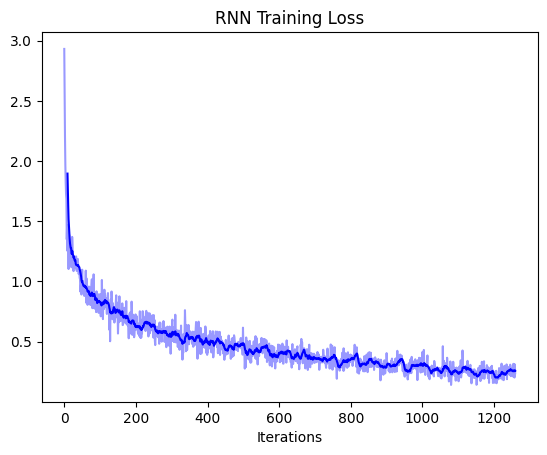

In [ ]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

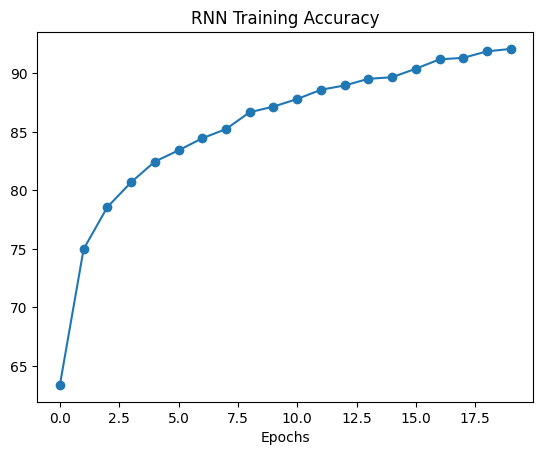

In [ ]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

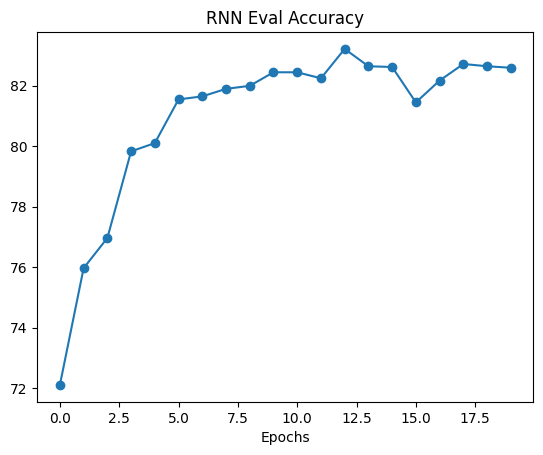

In [ ]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [ ]:
# Optional
# train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

## Use Your RNN: Try Your Own Name


In [ ]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [ ]:
model = rnn_model
model.eval()
model.cpu()

############################################################################
name = "Azizi"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Azizi
[26 25  8 25  8 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Italian
